09. Pytorch Model Deployment 

In [3]:
# Continue with regular imports 
import matplotlib.pyplot as plt 
import torch 
import torchvision 
import tqdm

from torch import nn 
from torchvision import transforms 
from torchinfo import summary
from going_modular import data_setup,engine 
from helper_functions import download_data, set_seeds, plot_loss_curves 


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
# Download pizza, steak, sushi images from GitHub 
data_20_percent_path = download_data("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")
data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [6]:
# Setup directory paths to train and test images 
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

In [9]:
# 1. Setup pretrained EffNetB2 weights 
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT 

# 2. Get EffNetB2 transforms 
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model 
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb2.parameters():
    param.requires_grad=False


In [10]:
# Check out EffNetB2 classifier head 
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [11]:
# 5. Update the classifier head 
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=3)
)

In [12]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms. 
    Args:
        num_classes (int, optional) : number of classes in the classifier head. Defaults to 3. 

        seed (int, optional) : random seed value. Defaults to 42.append()

    Returns:
        model (torch.nn.Module) : EffNetB2 feature extractor model. 

        transforms (torchvision.transforms) : EffNetB2 image transforms.    
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model 
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT 
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all the layers in base model 
    for param in model.parameters():
        param.requires_grad=False 

    # 5. Change classifier head with random seed for reproducibility 
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408,
                  out_features=num_classes)
    )
    return model, transforms

In [13]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [14]:
from torchinfo import summary 
summary(effnetb2,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [15]:
# Setup DataLoaders 
from going_modular import data_setup 
train_dataloader_effnetb2, test_dataloader_effnetb2,class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                                test_dir = test_dir,
                                                                                                transform=effnetb2_transforms,
                                                                                                batch_size=32)

In [17]:
from going_modular import engine 

# Setup optimizer 
optimizer = torch.optim.Adam(params = effnetb2.parameters(),
                             lr=1e-3)

# Setup loss function 
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model 
set_seeds()
effnetb2_results = engine.train(model = effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)


 10%|█         | 1/10 [00:30<04:37, 30.84s/it]

Epoch: 1 | train_loss: 0.9804 | train_acc: 0.5646 | test_loss: 0.7385 | test_acc: 0.9284


 20%|██        | 2/10 [01:00<04:02, 30.28s/it]

Epoch: 2 | train_loss: 0.6843 | train_acc: 0.8729 | test_loss: 0.5931 | test_acc: 0.9347


 30%|███       | 3/10 [01:31<03:32, 30.38s/it]

Epoch: 3 | train_loss: 0.5644 | train_acc: 0.8979 | test_loss: 0.4820 | test_acc: 0.9347


 40%|████      | 4/10 [02:02<03:03, 30.63s/it]

Epoch: 4 | train_loss: 0.4720 | train_acc: 0.8667 | test_loss: 0.4185 | test_acc: 0.9443


 50%|█████     | 5/10 [02:33<02:35, 31.02s/it]

Epoch: 5 | train_loss: 0.4309 | train_acc: 0.8729 | test_loss: 0.3725 | test_acc: 0.9568


 60%|██████    | 6/10 [03:05<02:05, 31.28s/it]

Epoch: 6 | train_loss: 0.3748 | train_acc: 0.8938 | test_loss: 0.3456 | test_acc: 0.9443


 70%|███████   | 7/10 [03:36<01:33, 31.22s/it]

Epoch: 7 | train_loss: 0.3367 | train_acc: 0.9083 | test_loss: 0.3123 | test_acc: 0.9506


 80%|████████  | 8/10 [04:08<01:02, 31.34s/it]

Epoch: 8 | train_loss: 0.3237 | train_acc: 0.9250 | test_loss: 0.3014 | test_acc: 0.9688


 90%|█████████ | 9/10 [04:39<00:31, 31.33s/it]

Epoch: 9 | train_loss: 0.3657 | train_acc: 0.8625 | test_loss: 0.2753 | test_acc: 0.9381


100%|██████████| 10/10 [05:10<00:00, 31.09s/it]

Epoch: 10 | train_loss: 0.2551 | train_acc: 0.9437 | test_loss: 0.2639 | test_acc: 0.9597


3.4 Inspecting EffNetB2 loss curves 

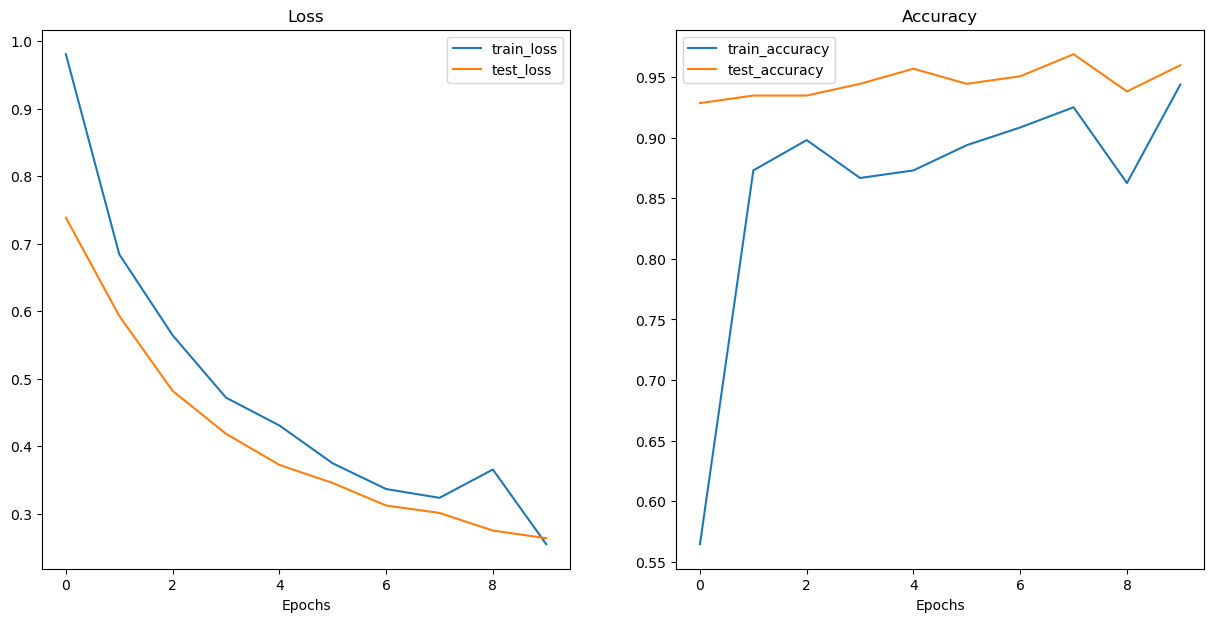

In [18]:
from helper_functions import plot_loss_curves 

plot_loss_curves(effnetb2_results)

In [19]:
from going_modular import utils 

# Save the model 
utils.save_model(model = effnetb2,
                 target_dir= "models",
                 model_name = "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [20]:
from pathlib import Path 

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)

print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [21]:
# Count number of parameters in EffNetB2 
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [22]:
# Create a dictionary with EffNetB2 statistics 
effnetb2_stats = {"test_loss" : effnetb2_results["test_loss"][-1],
                  "test_acc" : effnetb2_results["test_acc"][-1],
                  "number_of_parameters" : effnetb2_total_params,
                  "model_size (MB)" : pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.2639485955238342,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

In [30]:
# Check out ViT head layer 
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [31]:
def create_vit_model(num_classes : int=3,
                     seed : int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.add()
    Args:
        num_classes (int, optional) : number of target classes. Defaults to 3. 

        seed (int, optional) : random seed value for output layer. Defaults to 42. 

    Returns:
        model (torch.nn.Module) : ViT-B/16 feature extractor model. 

        transforms (torchvision.transforms) : ViT-B/16 image transforms. 

    """
    # Create ViT-B_16 pretrained weights, transforms and model 
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT 
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model 
    for param in model.parameters():
        param.requires_grad = False 
    
    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed=seed)
    model.heads = nn.Sequential(
        nn.Linear(in_features=768,
                  out_features=num_classes)
    )

    return model, transforms 



In [32]:
# Create ViT model and transforms 
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)


In [33]:
from torchinfo import summary 
summary(model = vit,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

4.1 Create DataLoaders for ViT 

In [34]:
# Setup ViT DataLoaders 
from going_modular import data_setup 

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [35]:
from going_modular import engine 

# Setup optimizer 
optimizer = torch.optim.Adam(params = vit.parameters(),
                             lr=1e-3)

# Setup loss function 
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility 
set_seeds()
vit_results = engine.train(model = vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=10,
                           device=device)

 10%|█         | 1/10 [01:33<14:04, 93.84s/it]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290


 20%|██        | 2/10 [03:09<12:38, 94.82s/it]

Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602


 30%|███       | 3/10 [04:44<11:04, 94.89s/it]

Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693


 40%|████      | 4/10 [06:23<09:40, 96.68s/it]

Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722


 50%|█████     | 5/10 [08:03<08:08, 97.69s/it]

Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784


 60%|██████    | 6/10 [09:39<06:28, 97.13s/it]

Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722


 70%|███████   | 7/10 [11:14<04:49, 96.52s/it]

Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784


 80%|████████  | 8/10 [12:48<03:11, 95.80s/it]

Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722


 90%|█████████ | 9/10 [14:25<01:36, 96.06s/it]

Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784


100%|██████████| 10/10 [15:59<00:00, 95.96s/it]

Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


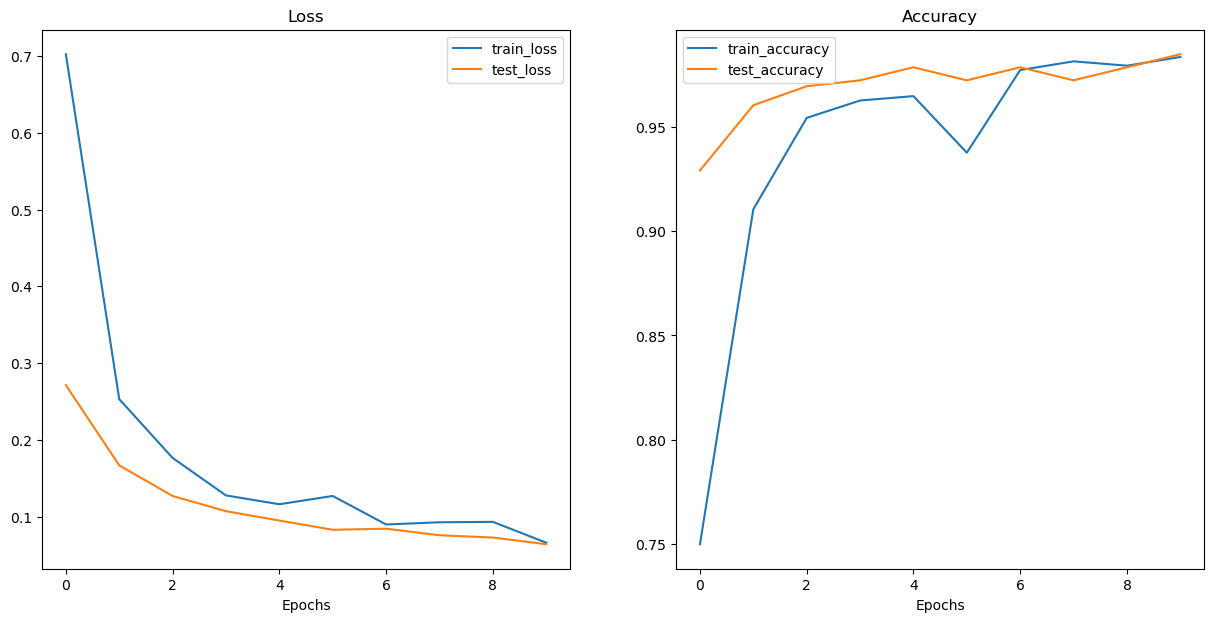

In [36]:
from helper_functions import plot_loss_curves 
plot_loss_curves(results = vit_results)

In [37]:
# Save the model 
from going_modular import utils 
utils.save_model(model=vit,
                 target_dir="models",
                 model_name = "09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [40]:
from pathlib import Path 

# Get the model size in bytes then convert to megabytes  
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)

print(f"Pretrained ViT feature extractor model size : {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size : 327 MB


In [41]:
# Count number of parameters in ViT 
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params 

85800963

In [44]:
# Create ViT statistics dictionary 
vit_stats = {"test_loss" : vit_results["test_loss"][-1],
             "test_acc" : vit_results["test_acc"][-1],
             "number_of_parameters" : vit_total_params,
             "model_size (MB)" : pretrained_vit_model_size}
vit_stats

{'test_loss': 0.06418208978138865,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

In [45]:
from pathlib import Path 

# Get all test data paths 
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/911808.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1245545.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/705150.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/1203702.jpg')]

In [47]:
import pathlib 
import torch 

from PIL import Image 
from timeit import default_timer as timer 
from tqdm.auto import tqdm 
from typing import List, Dict 

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time 
def pred_and_store(paths: List[pathlib.Path],
                   model : torch.nn.Module,
                   transform : torchvision.transforms,
                   class_names : List[str],
                   device : str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaries 
    pred_list = []

    # 3. Loop through target paths 
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample 
        pred_dict = {}

        # 5. Get the sample path and ground truth class name 
        pred_dict["image_path"] = path 
        class_name = path.parent.stem 
        pred_dict["class_name"] = class_name 

        # 6. Start the prediction timer 
        start_time = timer()

        # 7. Open image path 
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device 
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode 
        model.to(device)
        model.eval()

        # 10. Get prediction probability, prediction label and prediction class 
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit,dim=1)
            pred_label = torch.argmax(pred_prob,dim=1)
            pred_class = class_names[pred_label.cpu()]

            # 11. Make sure things in the dictionary are on CPU 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(),4)
            pred_dict["pred_class"] = pred_class  

            # 12. End the timera nd calculate time per pred 
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time,4)
        
        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class 

        # 14. Add the dictionary to the list of preds 
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries 
    return pred_list 

In [48]:
# Make predictions across test dataset with EffNetB2 
effnetb2_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                          model = effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

100%|██████████| 150/150 [00:07<00:00, 19.90it/s]


In [49]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/911808.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.7635,
  'pred_class': 'sushi',
  'time_for_pred': 0.2993,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.8729,
  'pred_class': 'sushi',
  'time_for_pred': 0.0535,
  'correct': True}]

In [50]:
# Turn the test_pred_dicts into a DataFrame 
import pandas as pd 
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/9...,sushi,0.7635,sushi,0.2993,True
1,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.8729,sushi,0.0535,True
2,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.8863,sushi,0.0515,True
3,data/pizza_steak_sushi_20_percent/test/sushi/7...,sushi,0.5620,sushi,0.0525,True
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.8826,sushi,0.0554,True


In [51]:
# Check nummber of correct predictions 
effnetb2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [52]:
# Find the average time per prediction 
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(),4)
print(f"EffNetB2 average time per prediction : {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction : 0.0499 seconds


In [53]:
# Add EffNetB2 average prediction time to stats dictionary 
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred 
effnetb2_stats

{'test_loss': 0.2639485955238342,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.0499}

In [54]:
# Make list of prediction dictionaries with ViT feature extractor model on test images 
vit_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                     model = vit,
                                     transform=vit_transforms,
                                     class_names= class_names,
                                     device= "cpu")

100%|██████████| 150/150 [00:25<00:00,  5.78it/s]


In [55]:
# Check the first couple of ViT predictions on the test dataset 
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/911808.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9986,
  'pred_class': 'sushi',
  'time_for_pred': 0.5452,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9889,
  'pred_class': 'sushi',
  'time_for_pred': 0.1809,
  'correct': True}]

In [57]:
# Turn vit_test_pred_dicts into a DataFrame 
import pandas as pd 
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/sushi/9...,sushi,0.9986,sushi,0.5452,True
1,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.9889,sushi,0.1809,True
2,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9859,sushi,0.1733,True
3,data/pizza_steak_sushi_20_percent/test/sushi/7...,sushi,0.9447,sushi,0.1680,True
4,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9589,sushi,0.1485,True


In [58]:
vit_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [59]:
# Calculate average time per prediction for ViT model 
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(),4)
print(f"ViT average time per prediction : {vit_average_time_per_pred} seconds")

ViT average time per prediction : 0.1722 seconds


In [60]:
# Add average prediction time for ViT model on CPU 
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06418208978138865,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.1722}

In [62]:
# Turn stat dictionaries into DataFrame 
df = pd.DataFrame([effnetb2_stats,vit_stats])

# Add Column for model names 
df["model"] = ["EffNetB2","ViT"]

# Convert accuracy to percentages 
df["test_acc"] = round(df["test_acc"] * 100,2)
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.263949,95.97,7705221,29,0.0499,EffNetB2
1,0.064182,98.47,85800963,327,0.1722,ViT


In [67]:
# Compare ViT to EffNetB2 across different characteristics 
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns = ["ViT to EffNetB2 ratios"]).T


,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.243161,1.02605,11.135432,11.275862,3.450902


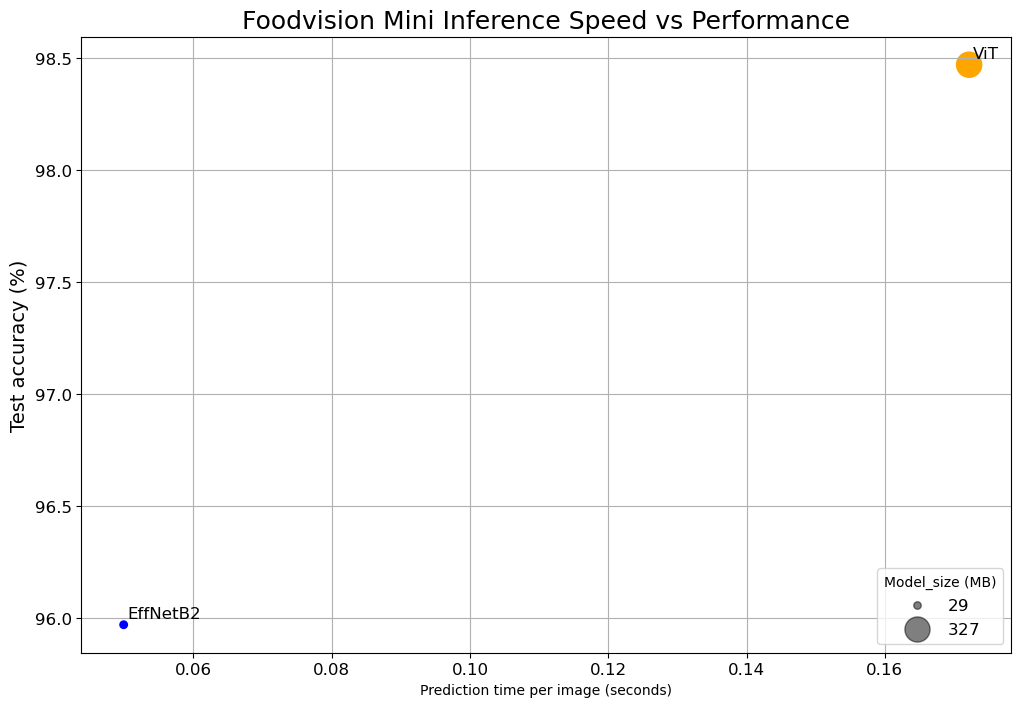

In [70]:
# 1. Create a plot from model comparison DataFrame 
fig, ax = plt.subplots(figsize=(12,8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue","orange"],
                     s="model_size (MB)")

# 2. Add titles, labels and customize fontsize for aesthetics 
ax.set_title("Foodvision Mini Inference Speed vs Performance",fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)")
ax.set_ylabel("Test accuracy (%)",fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# 3. Annotate with model names 
for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"] + 0.0006,
                    row["test_acc"] + 0.03),
                    size=12)
    
# 4. Create a legend based on model sizes 
handles, labels = scatter.legend_elements(prop="sizes",
                                              alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc = "lower right",
                              title="Model_size (MB)",
                              fontsize = 12)

# Save the figure 
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

In [73]:
import gradio as gr 
def hello(name):
    return "hi  " + name + "!!!"

demo = gr.Interface(fn=hello, inputs="text",outputs="text")

if __name__ == "__main__":
    demo.launch()


Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
